# CarND-Advanced-Lane-Lines

## Setup

In [8]:
import os
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip

IMG_WIDTH = 1280
IMG_HEIGHT = 720
LANE_WIDTH_PX = 640
YM_PER_PX = 30 / IMG_HEIGHT
XM_PER_PX = 3.7 / LANE_WIDTH_PX
DEFAULT_HLS_S_THRES = (170, 255)
DEFAULT_SX_THRES = (20, 100)
DEFAULT_SOBEL_KERNEL = 3
img_file_pattern='./camera_cal/calibration*.jpg'

%matplotlib inline

## Camera Calibration

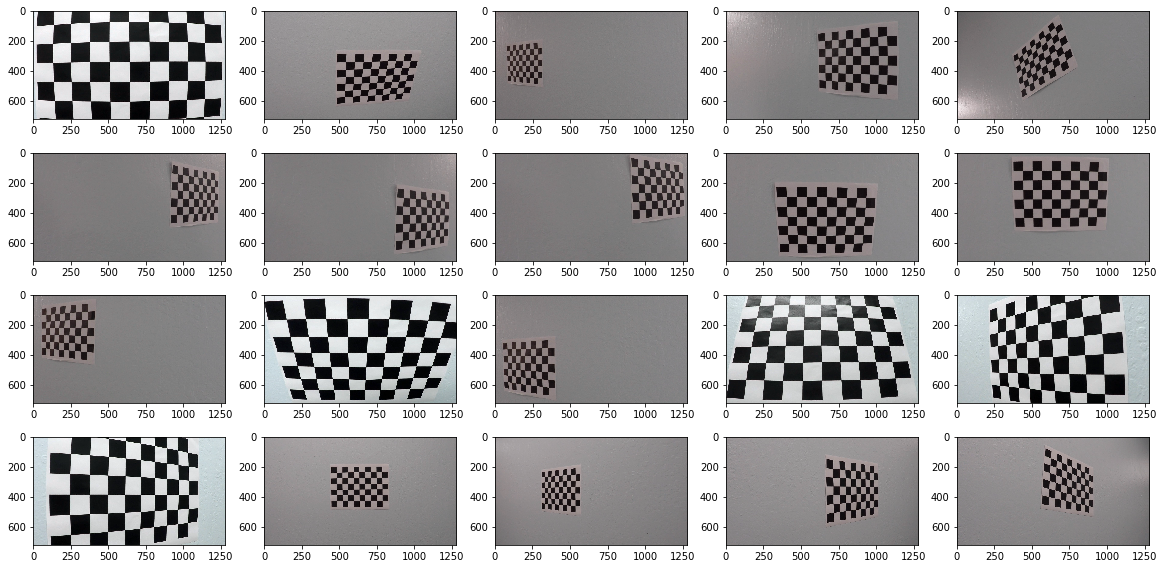

In [9]:
images = glob.glob('camera_cal/calibration*.jpg')
plt.figure(figsize=(20, 10))
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    plt.subplot(len(images)//5, 5, idx+1)
    plt.imshow(img)

In [10]:
def camera_calibration(image_file_pattern, nx=9, ny=6):
    objpoints, imgpoints, image_size = chessboard_corners(image_file_pattern, nx=nx, ny=ny)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def chessboard_corners(image_file_pattern, nx=9, ny=6):
    objpoints = []
    imgpoints = []
    image_files = glob.glob(image_file_pattern)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    if len(image_files) == 0:
        raise FileNotFoundError('No image files: {}'.format(image_file_pattern))
    image_size = None

    for image_file in image_files:
        image = cv2.imread(image_file)
        image_size = (image.shape[1], image.shape[0])
        image_corners = chessboard_corner_image(image, nx=nx, ny=ny)
        if image_corners is not None:
            imgpoints.append(image_corners)
            objpoints.append(objp)

    return objpoints, imgpoints, image_size

def chessboard_corner_image(image, nx=9, ny=6, is_gray_image=False):
    if is_gray_image is False:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    image_corners = None
    if ret is True:
        return corners
    else:
        return None

mtx, dist = camera_calibration(img_file_pattern, nx=9, ny=6)

## Modules

In [11]:
def find_lane_lines(binary_warped, visualize=False, nwindows=9):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    if visualize:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def show_inside_lane(undist_img, binary_warped, Minv, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0]))
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)  # image should be undistorted version
    return result

def dist_from_center(left_fitx, right_fitx, img_width=IMG_WIDTH, xm_per_pix=XM_PER_PX):
    left_x = left_fitx[-1]
    right_x = right_fitx[-1]
    center_x = left_x + ((right_x - left_x) / 2)
    return ((img_width / 2) - center_x) * xm_per_pix

def get_curvature_radius(leftx, rightx, ploty, xm_per_pix=XM_PER_PX, ym_per_pix=YM_PER_PX):
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    center_curverad = np.average([left_curverad, right_curverad])
    return center_curverad, left_curverad, right_curverad

def abs_sobel_threshold(img, orient='x', sobel_kernel=DEFAULT_SOBEL_KERNEL, thres=None, is_gray=False):
    if is_gray is True:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError('orient must be "x" or "y".')
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    if thres is not None:
        sbinary = np.zeros_like(scaled_sobel)
        sbinary[(scaled_sobel >= thres[0]) & (scaled_sobel <= thres[1])] = 1
        binary_output = sbinary
    else:
        binary_output = scaled_sobel
    return binary_output

def grad_color_threshold(img, s_thres=DEFAULT_HLS_S_THRES, sx_thres=DEFAULT_SX_THRES,
                         sobel_kernel=DEFAULT_SOBEL_KERNEL):
    img = np.copy(img)
    img = cv2.GaussianBlur(img, (sobel_kernel, sobel_kernel), 0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    sobel_l = abs_sobel_threshold(l_channel, sobel_kernel=sobel_kernel)
    sobel_s = abs_sobel_threshold(s_channel, sobel_kernel=sobel_kernel)
    sobel_l_and_s = cv2.bitwise_or(sobel_l, sobel_s)
    sxbinary = np.zeros_like(sobel_l_and_s)
    sxbinary[(sobel_l_and_s >= sx_thres[0]) & (sobel_l_and_s <= sx_thres[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thres[0]) & (s_channel <= s_thres[1])] = 1
    color_binary = np.dstack((np.ones_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

def transform(img, src_corners, dst_corners, is_gray=False):
    if is_gray is False:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32(src_corners)
    dst = np.float32(dst_corners)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(gray, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped, Minv, M

def transform_img(img, offset=(30, 0), is_gray=False):
    img_size = (img.shape[1], img.shape[0])
    offset_x = offset[0]
    offset_y = offset[1]
    src = [[100, img_size[1]],
           [img_size[0] * 0.45, img_size[1] * 0.63],
           [img_size[0] * 0.55, img_size[1] * 0.63],
           [img_size[0] - 100, img_size[1]]]
    dst = [[src[0][0] + offset_x, img_size[1] + offset_y],
           [src[0][0] + offset_x, 0 + offset_y],
           [src[-1][0] - offset_x, 0 - offset_y],
           [src[-1][0] - offset_x, img_size[1] - offset_y]]
    return transform(img, src, dst, is_gray=is_gray)

## Pipeline

In [12]:
def image_processing(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    _, combined_binary = grad_color_threshold(img)
    binary_warped, Minv, M = transform_img(combined_binary, is_gray=True)
    left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane_lines(binary_warped)
    result = show_inside_lane(undist, binary_warped, Minv, left_fitx, right_fitx, ploty)
    lane_mid = (left_fitx + right_fitx) / 2.0
    off_center = dist_from_center(left_fitx, right_fitx)
    curve_rad, left_curverad, right_curverad = get_curvature_radius(left_fitx, right_fitx, ploty)
    cv2.putText(result, 'Radius of Curvature = {:.2f}(m)'.format(curve_rad),
                (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Distance from Center = {:.2f}(m)'.format(off_center),
                (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return result

def video_processing(mtx, dist, input_video="./project_video.mp4", output_video='output_video.mp4'):
    clip = VideoFileClip(input_video)
    test_clip = clip.fx(transform_image, mtx, dist)
    test_clip.write_videofile(output_video, audio=False, progress_bar=False)


def transform_image(clip, mtx, dist):
    def _transform(img):
        return image_processing(img, mtx, dist)
    return clip.fl_image(_transform)

## Process Video

In [13]:
output_video='output_video.mp4'
%time video_processing(mtx, dist, output_video=output_video)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 3min 18s
